# Yolov5 Pytorch
This notebook shows how to compile Yolov5/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK.

**Reference:** https://pytorch.org/hub/ultralytics_yolov5/

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
%pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.1.2.2.0.0 neuron-cc[tensorflow] "protobuf<4" torchvision
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

## 2) Initialize libraries and prepare input samples

In [ ]:
import torch
import torch_neuron
from torchvision import models

model_type='l'
assert(model_type in ['n', 's', 'm', 'l', 'x'])

x = torch.rand([1, 3, 640, 640], dtype=torch.float32)

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
model = torch.hub.load('ultralytics/yolov5', f'yolov5{model_type}', pretrained=True)
model.eval()

y = model(x) # warmup
try:    
    traced = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")

## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
import torch
import torch.neuron
model_neuron = torch.neuron.trace( model, example_inputs=x)

## Export to saved model
model_neuron.save("yolov5_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

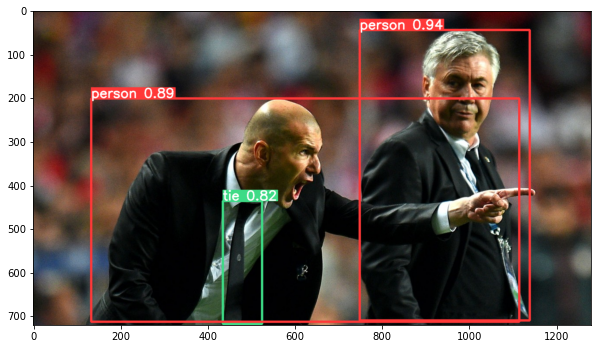

In [9]:
%matplotlib inline
import sys
if '..' not in sys.path: sys.path.append('..')
import torch
import torch.neuron
import matplotlib.pyplot as plt
from common import processing

img = processing.load_sample_imgB()
model_neuron = torch.load('yolov5_neuron.pt')

x = processing.preprocess_coco(img)
x = torch.from_numpy(x)

y = model_neuron(x)
out_img = processing.postprocess_yolov5(y, img)

plt.figure(figsize=(10,10))
plt.imshow(out_img)